In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
from scipy.optimize import minimize

In [ ]:
# Load and preprocess the stock data
df = pd.read_csv(r"C:\Gagan\University\Sem 5\Discrete Maths\Project\Graph-Theory-for-Portfolio-Optimization\ind_nifty500list.csv")
df['Symbol'] = df['Symbol'] + '.NS'

industry_abbr = {
    'Financial Services': 'FIN',
    'Diversified': 'DIV',
    'Capital Goods': 'CAP',
    'Construction Materials': 'CON',
    'Chemicals': 'CHE',
    'Healthcare': 'HEA',
    'Power': 'POW',
    'Metals & Mining': 'MET',
    'Services': 'SER',
    'Oil Gas & Consumable Fuels': 'OIL',
    'Fast Moving Consumer Goods': 'FMC',
    'Consumer Services': 'CSV',
    'Forest Materials': 'FOR',
    'Information Technology': 'IT',
    'Textiles': 'TEX',
    'Automobile and Auto Components': 'AUT',
    'Consumer Durables': 'CND',
    'Realty': 'REA',
    'Telecommunication': 'TEL',
    'Construction': 'CST',
    'Media Entertainment & Publication': 'MED'
}

df['Industry_Abbr'] = df['Industry'].map(industry_abbr)
df['Industry_Symbol_Abbr'] = df['Industry_Abbr'] + '_' + df['Symbol']

df

,Company Name,Industry,Symbol,Series,ISIN Code,Industry_Abbr,Industry_Symbol_Abbr
0,360 ONE WAM Ltd.,Financial Services,360ONE.NS,EQ,INE466L01038,FIN,FIN_360ONE.NS
1,3M India Ltd.,Diversified,3MINDIA.NS,EQ,INE470A01017,DIV,DIV_3MINDIA.NS
2,ABB India Ltd.,Capital Goods,ABB.NS,EQ,INE117A01022,CAP,CAP_ABB.NS
3,ACC Ltd.,Construction Materials,ACC.NS,EQ,INE012A01025,CON,CON_ACC.NS
4,AIA Engineering Ltd.,Capital Goods,AIAENG.NS,EQ,INE212H01026,CAP,CAP_AIAENG.NS
...,...,...,...,...,...,...,...
495,Zee Entertainment Enterprises Ltd.,Media Entertainment & Publication,ZEEL.NS,EQ,INE256A01028,MED,MED_ZEEL.NS
496,Zensar Technolgies Ltd.,Information Technology,ZENSARTECH.NS,EQ,INE520A01027,IT,IT_ZENSARTECH.NS
497,Zomato Ltd.,Consumer Services,ZOMATO.NS,EQ,INE758T01015,CSV,CSV_ZOMATO.NS
498,Zydus Lifesciences Ltd.,Healthcare,ZYDUSLIFE.NS,EQ,INE010B01027,HEA,HEA_ZYDUSLIFE.NS


In [3]:
# Download stock data
tickers = df['Symbol'].to_list()
data = yf.download(tickers, start="2019-04-01", end="2024-03-31")["Close"]
data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')

symbol_abbr = pd.Series(df.Industry_Symbol_Abbr.values, index=df.Symbol).to_dict()
data.rename(columns=symbol_abbr, inplace=True)
sector_sorted_columns = sorted(data.columns, key=lambda x: x.split('_')[0])
data = data[sector_sorted_columns]

data

[*********************100%***********************]  500 of 500 completed

9 Failed downloads:
['INDGN.NS', 'BHARTIHEXA.NS', 'AADHARHFC.NS', 'GODIGIT.NS', 'EMCURE.NS', 'UNITDSPR.NS', 'AEGISLOG.NS', 'TBOTEK.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-04-01 -> 2024-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1554057000, endDate = 1711823400")')
['TV18BRDCST.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-04-01 -> 2024-03-31)')


Ticker,AUT_APOLLOTYRE.NS,AUT_ARE&M.NS,AUT_ASAHIINDIA.NS,AUT_BAJAJ-AUTO.NS,AUT_BALKRISIND.NS,AUT_BHARATFORG.NS,AUT_BOSCHLTD.NS,AUT_CEATLTD.NS,AUT_CIEINDIA.NS,AUT_CRAFTSMAN.NS,...,TEL_ROUTE.NS,TEL_TATACOMM.NS,TEL_TEJASNET.NS,TEL_TTML.NS,TEX_ALOKINDS.NS,TEX_KPRMILL.NS,TEX_PAGEIND.NS,TEX_TRIDENT.NS,TEX_VTL.NS,TEX_WELSPUNLIV.NS
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,225.850006,NaN,257.000000,2915.649902,990.700012,511.600006,18105.849609,1140.050049,232.600006,NaN,...,NaN,379.090332,171.100006,2.918400,4.950000,113.190002,25531.800781,7.140000,217.610001,61.150002
2019-04-02,221.250000,NaN,255.600006,2853.100098,1003.349976,514.200012,17946.250000,1130.550049,233.149994,NaN,...,NaN,375.551208,169.000000,2.966243,5.150000,115.309998,25192.949219,6.945000,214.979996,60.200001
2019-04-03,219.850006,NaN,253.800003,2847.300049,996.150024,503.799988,18005.949219,1100.550049,229.500000,NaN,...,NaN,371.918945,168.399994,2.918400,5.150000,112.860001,24662.800781,6.835000,214.350006,58.700001
2019-04-04,222.899994,NaN,249.399994,2859.100098,985.549988,507.950012,17832.300781,1111.849976,227.100006,NaN,...,NaN,369.901001,168.250000,2.870557,4.950000,112.540001,24439.599609,6.745000,214.509995,57.450001
2019-04-05,224.050003,NaN,244.899994,2861.649902,986.150024,512.349976,17994.849609,1124.449951,224.550003,NaN,...,NaN,374.744049,169.949997,2.918400,4.800000,114.650002,24012.199219,6.815000,214.139999,57.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,461.000000,756.150024,520.450012,8750.599609,2309.550049,1102.000000,30066.250000,2528.149902,441.649994,3972.350098,...,1603.449951,1908.199951,692.750000,78.250000,27.049999,801.200012,34092.851562,37.000000,433.049988,141.350006
2024-03-22,468.350006,778.000000,530.799988,8945.250000,2276.050049,1128.949951,30178.699219,2593.000000,445.549988,4149.549805,...,1600.550049,1922.650024,687.000000,78.550003,27.350000,794.000000,34449.851562,38.650002,439.299988,141.649994
2024-03-26,471.450012,774.200012,528.799988,8960.549805,2266.399902,1130.150024,30680.349609,2626.800049,445.100006,4172.049805,...,1600.500000,1947.599976,673.000000,76.650002,26.650000,826.250000,34609.500000,37.400002,441.399994,140.550003


In [4]:
# Remove stocks with more than two consecutive NaNs
def remove_stocks_with_consecutive_nans(data, max_consecutive_nans=2):
    nan_mask = data.isna()
    columns_to_drop = [col for col in nan_mask.columns if nan_mask[col].astype(int).groupby((~nan_mask[col]).cumsum()).cumsum().max() > max_consecutive_nans]
    data = data.drop(columns=columns_to_drop)
    return data

data = remove_stocks_with_consecutive_nans(data)
data

Ticker,AUT_APOLLOTYRE.NS,AUT_ASAHIINDIA.NS,AUT_BAJAJ-AUTO.NS,AUT_BALKRISIND.NS,AUT_BHARATFORG.NS,AUT_BOSCHLTD.NS,AUT_CEATLTD.NS,AUT_CIEINDIA.NS,AUT_EICHERMOT.NS,AUT_ENDURANCE.NS,...,TEL_ITI.NS,TEL_TATACOMM.NS,TEL_TEJASNET.NS,TEL_TTML.NS,TEX_ALOKINDS.NS,TEX_KPRMILL.NS,TEX_PAGEIND.NS,TEX_TRIDENT.NS,TEX_VTL.NS,TEX_WELSPUNLIV.NS
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,225.850006,257.000000,2915.649902,990.700012,511.600006,18105.849609,1140.050049,232.600006,2004.839966,1150.949951,...,100.050003,379.090332,171.100006,2.918400,4.950000,113.190002,25531.800781,7.140000,217.610001,61.150002
2019-04-02,221.250000,255.600006,2853.100098,1003.349976,514.200012,17946.250000,1130.550049,233.149994,2058.350098,1171.800049,...,104.400002,375.551208,169.000000,2.966243,5.150000,115.309998,25192.949219,6.945000,214.979996,60.200001
2019-04-03,219.850006,253.800003,2847.300049,996.150024,503.799988,18005.949219,1100.550049,229.500000,2020.270020,1169.000000,...,100.650002,371.918945,168.399994,2.918400,5.150000,112.860001,24662.800781,6.835000,214.350006,58.700001
2019-04-04,222.899994,249.399994,2859.100098,985.549988,507.950012,17832.300781,1111.849976,227.100006,2048.955078,1171.250000,...,102.750000,369.901001,168.250000,2.870557,4.950000,112.540001,24439.599609,6.745000,214.509995,57.450001
2019-04-05,224.050003,244.899994,2861.649902,986.150024,512.349976,17994.849609,1124.449951,224.550003,2098.030029,1172.599976,...,101.550003,374.744049,169.949997,2.918400,4.800000,114.650002,24012.199219,6.815000,214.139999,57.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,461.000000,520.450012,8750.599609,2309.550049,1102.000000,30066.250000,2528.149902,441.649994,3918.949951,1779.900024,...,256.100006,1908.199951,692.750000,78.250000,27.049999,801.200012,34092.851562,37.000000,433.049988,141.350006
2024-03-22,468.350006,530.799988,8945.250000,2276.050049,1128.949951,30178.699219,2593.000000,445.549988,3988.399902,1786.400024,...,261.000000,1922.650024,687.000000,78.550003,27.350000,794.000000,34449.851562,38.650002,439.299988,141.649994
2024-03-26,471.450012,528.799988,8960.549805,2266.399902,1130.150024,30680.349609,2626.800049,445.100006,3911.100098,1762.849976,...,252.649994,1947.599976,673.000000,76.650002,26.650000,826.250000,34609.500000,37.400002,441.399994,140.550003


In [5]:
# Calculate log returns
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.dropna(axis=1, how='all')
log_returns = log_returns.drop(log_returns.index[0])
log_returns

Ticker,AUT_APOLLOTYRE.NS,AUT_ASAHIINDIA.NS,AUT_BAJAJ-AUTO.NS,AUT_BALKRISIND.NS,AUT_BHARATFORG.NS,AUT_BOSCHLTD.NS,AUT_CEATLTD.NS,AUT_CIEINDIA.NS,AUT_EICHERMOT.NS,AUT_ENDURANCE.NS,...,TEL_ITI.NS,TEL_TATACOMM.NS,TEL_TEJASNET.NS,TEL_TTML.NS,TEX_ALOKINDS.NS,TEX_KPRMILL.NS,TEX_PAGEIND.NS,TEX_TRIDENT.NS,TEX_VTL.NS,TEX_WELSPUNLIV.NS
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-02,-0.020578,-0.005462,-0.021687,0.012688,0.005069,-0.008854,-0.008368,0.002362,0.026340,0.017953,...,0.042560,-0.009380,-0.012350,0.016261,0.039609,0.018556,-0.013361,-0.027691,-0.012159,-0.015658
2019-04-03,-0.006348,-0.007067,-0.002035,-0.007202,-0.020433,0.003321,-0.026894,-0.015779,-0.018674,-0.002392,...,-0.036581,-0.009719,-0.003557,-0.016261,0.000000,-0.021476,-0.021268,-0.015966,-0.002935,-0.025233
2019-04-04,0.013778,-0.017489,0.004136,-0.010698,0.008204,-0.009691,0.010215,-0.010513,0.014099,0.001923,...,0.020650,-0.005441,-0.000891,-0.016529,-0.039609,-0.002839,-0.009091,-0.013255,0.000746,-0.021525
2019-04-05,0.005146,-0.018208,0.000891,0.000609,0.008625,0.009074,0.011269,-0.011292,0.023669,0.001152,...,-0.011748,0.013008,0.010053,0.016529,-0.030772,0.018575,-0.017643,0.010325,-0.001726,-0.007864
2019-04-08,-0.017787,-0.017714,-0.002905,-0.007890,-0.017623,0.000006,-0.017313,-0.011196,-0.017679,-0.000810,...,-0.038650,-0.018562,0.028710,0.000000,-0.042560,-0.007090,-0.001507,-0.012551,0.013083,0.017392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,0.019605,0.017933,0.013229,0.012702,0.008475,0.006535,0.022642,0.017588,0.011639,0.015172,...,0.029924,0.010483,0.011761,0.001919,0.016776,0.013825,0.025519,0.017724,0.015241,0.001770
2024-03-22,0.015818,0.019691,0.022000,-0.014611,0.024161,0.003733,0.025328,0.008792,0.017566,0.003645,...,0.018952,0.007544,-0.008335,0.003827,0.011030,-0.009027,0.010417,0.043629,0.014329,0.002120
2024-03-26,0.006597,-0.003775,0.001709,-0.004249,0.001062,0.016486,0.012951,-0.001010,-0.019571,-0.013271,...,-0.032515,0.012893,-0.020589,-0.024486,-0.025927,0.039814,0.004624,-0.032876,0.004769,-0.007796


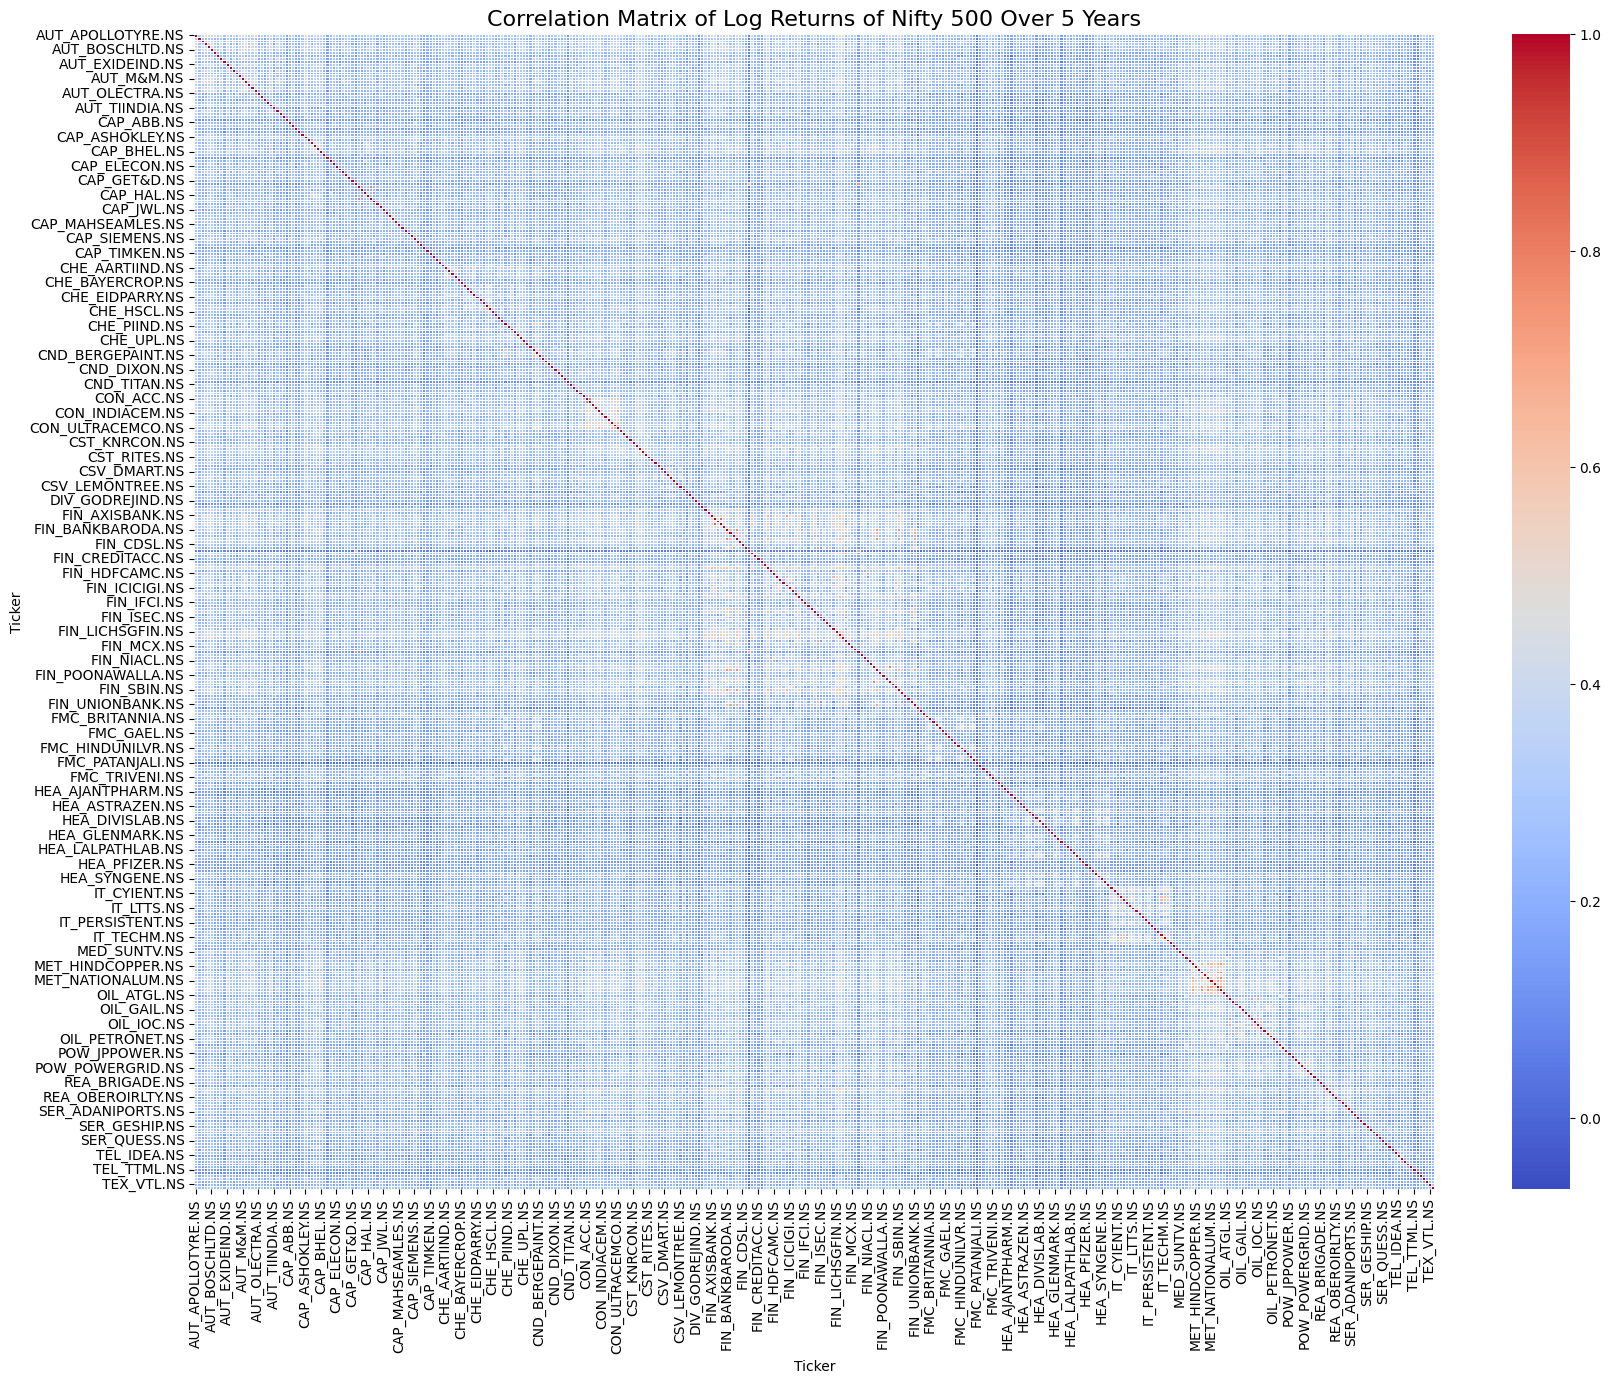

In [ ]:
# Calculate the correlation matrix
correlation_matrix = log_returns.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Matrix of Log Returns of Nifty 500 Over 5 Years", fontsize=16)
plt.savefig('Correlation Matrix of Log Returns of Nifty 500 Over 5 Years.png')
plt.show()

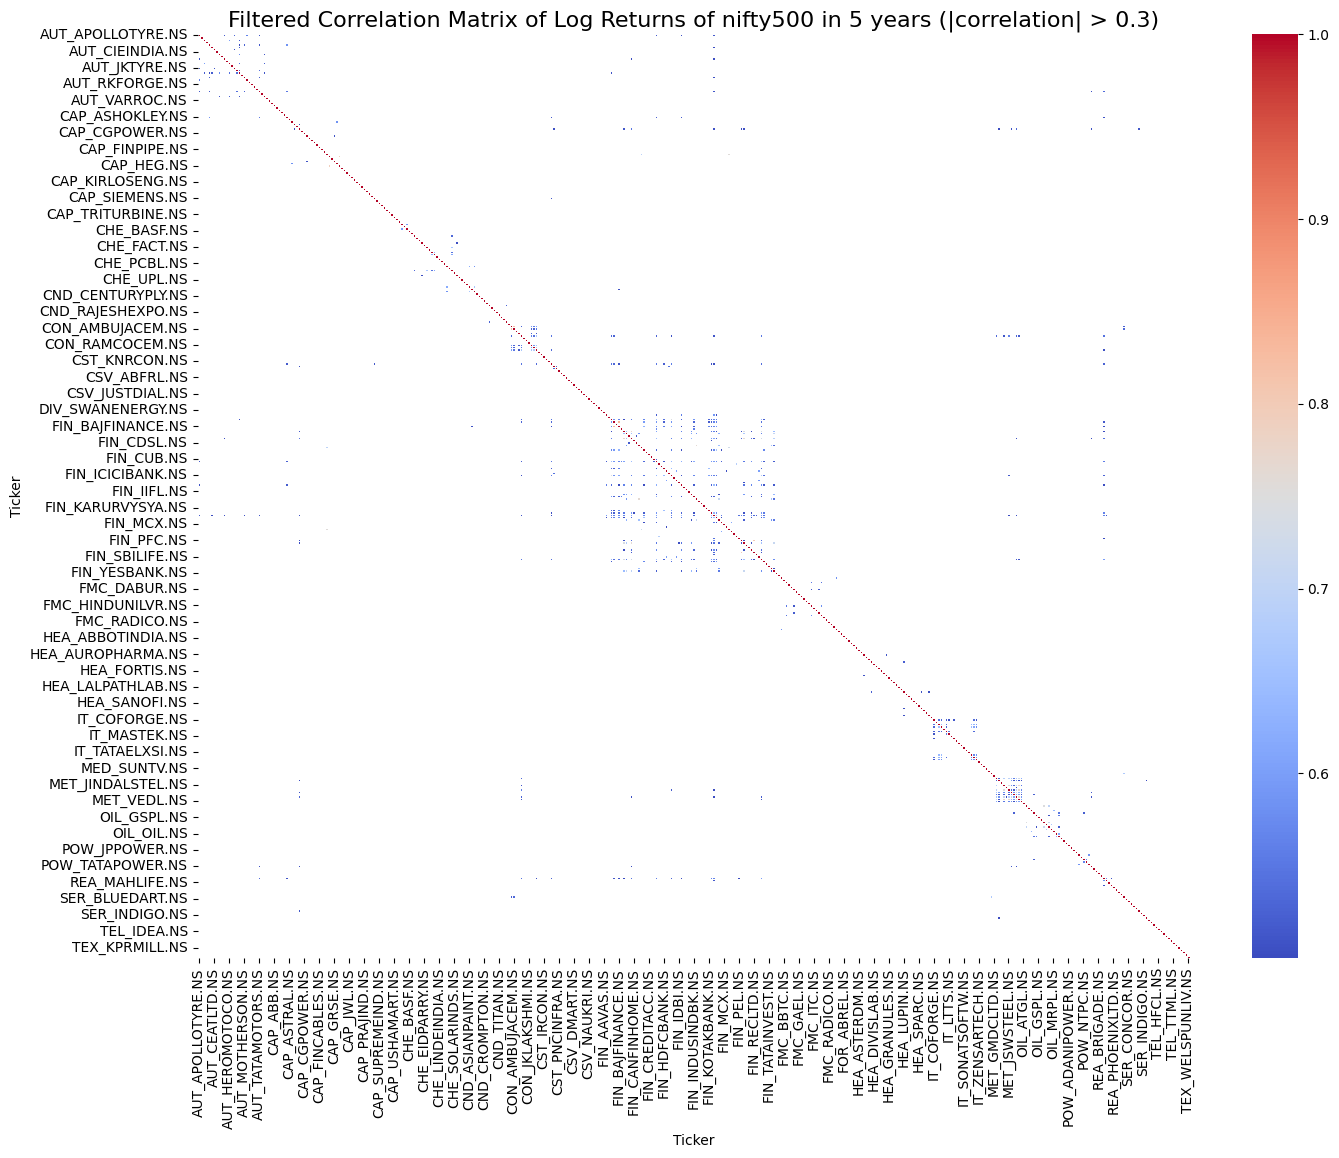

In [30]:
# Only display correlations with absolute values above threshold
threshold = 0.5
filtered_correlation = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

plt.figure(figsize=(16,12))
sns.heatmap(filtered_correlation, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Filtered Correlation Matrix of Log Returns of nifty500 in 5 years (|correlation| > 0.3)", fontsize=16)
plt.savefig('Filtered Correlation Matrix of Log Returns of nifty500 in 5 years.png')
plt.show()

In [31]:
# Construct the graph using correlation threshold
G = nx.Graph()

for ticker in correlation_matrix.columns:
    G.add_node(ticker)

for i, stock1 in enumerate(correlation_matrix.columns):
    for j, stock2 in enumerate(correlation_matrix.columns):
        if i < j:
            corr_value = correlation_matrix.loc[stock1, stock2]
            if abs(corr_value) >= threshold:
                G.add_edge(stock1, stock2, weight=corr_value)

In [ ]:
# Apply Louvain method to detect clusters
partition = community_louvain.best_partition(G, weight='weight')
clusters = {}
for node, cluster_id in partition.items():
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(node)

In [ ]:
# Identify key stocks using a combination of centrality and clusters
centrality = nx.degree_centrality(G)
selected_stocks = []

# Select top central stocks from each cluster
for cluster_id, stocks in clusters.items():
    cluster_centrality = {stock: centrality[stock] for stock in stocks}
    top_stocks = sorted(cluster_centrality, key=cluster_centrality.get, reverse=True)[:max(1, len(stocks)//5)]
    selected_stocks.extend(top_stocks)

# Filter log returns for selected stocks
selected_log_returns = log_returns[selected_stocks]

In [45]:
# Optimize weights with minimum allocation constraint
def portfolio_annualized_performance(weights, log_returns):
    portfolio_return = np.sum(weights * log_returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, log_returns):
    p_return, p_volatility = portfolio_annualized_performance(weights, log_returns)
    return -p_return / p_volatility

# Minimum allocation constraint (e.g., 1%)
min_allocation = 0.01

constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights must be 1
    {'type': 'ineq', 'fun': lambda weights: weights - min_allocation}  # Each weight must be at least 1%
]

bounds = tuple((min_allocation, 1) for _ in range(len(selected_stocks)))
initial_weights = np.ones(len(selected_stocks)) / len(selected_stocks)

# Optimize weights using SLSQP method
optimized_results = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(selected_log_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_weights = optimized_results.x

# Normalize weights to ensure the sum is exactly 1
optimized_weights /= optimized_weights.sum()

# Portfolio returns
portfolio_returns = selected_log_returns.dot(optimized_weights)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

# Benchmark (Nifty 500) returns
benchmark = yf.download("^CRSLDX", start="2019-04-01", end="2024-03-31")["Close"].pct_change().dropna()
cumulative_benchmark_returns = (1 + benchmark).cumprod()

[*********************100%***********************]  1 of 1 completed


In [46]:
# Portfolio allocation details
portfolio_weights_df = pd.DataFrame({
    'Stock': selected_stocks,
    'Weight': optimized_weights
})

# Calculate the percentage allocation
portfolio_weights_df['Percentage Allocation'] = portfolio_weights_df['Weight'] * 100

# Display the percentage allocation of each stock in the portfolio
print("Portfolio Component Percentage Allocation:")
print(portfolio_weights_df.sort_values(by='Percentage Allocation', ascending=False))

Portfolio Component Percentage Allocation:
                 Stock    Weight  Percentage Allocation
240  POW_ADANIGREEN.NS  0.003571               0.357143
129    CSV_RTNINDIA.NS  0.003571               0.357143
97        CND_DIXON.NS  0.003571               0.357143
220        IT_TANLA.NS  0.003571               0.357143
8          AUT_JBMA.NS  0.003571               0.357143
..                 ...       ...                    ...
103      CND_VGUARD.NS  0.003571               0.357143
104      CND_VIPIND.NS  0.003571               0.357143
105   CND_WHIRLPOOL.NS  0.003571               0.357143
106      CON_GRASIM.NS  0.003571               0.357143
279  TEX_WELSPUNLIV.NS  0.003571               0.357143

[280 rows x 3 columns]


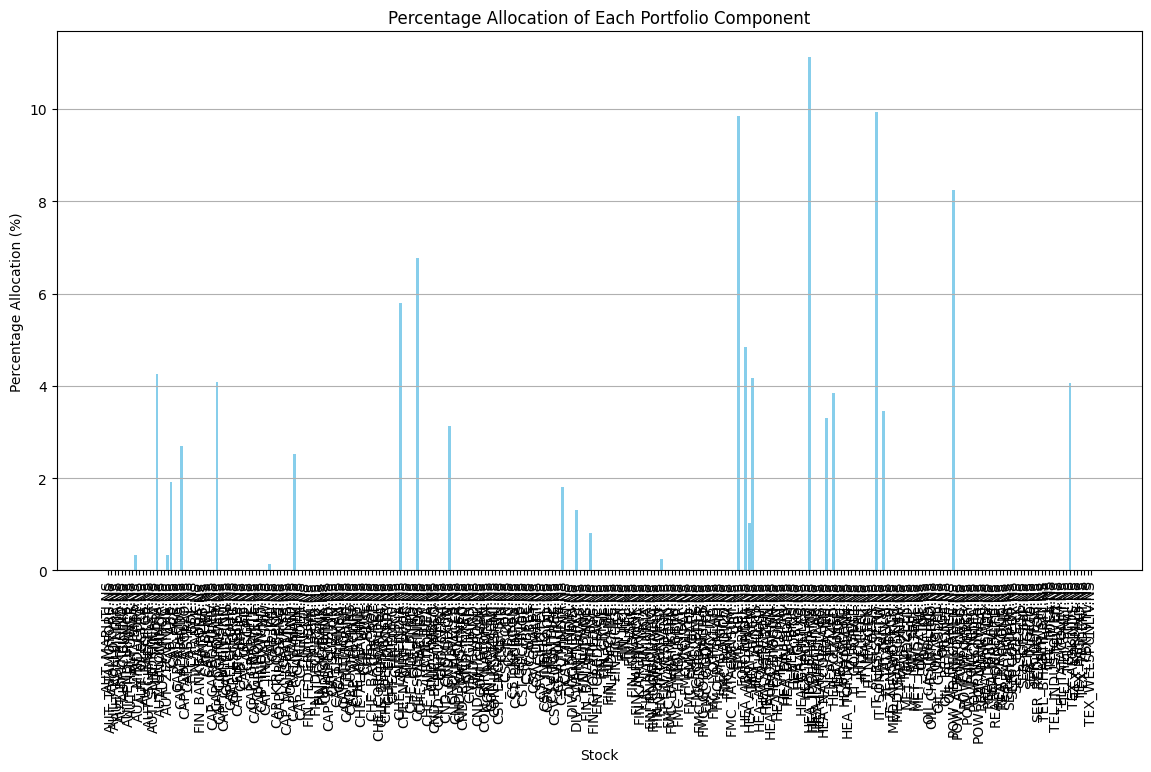

In [42]:
# Plot the percentage allocation as a bar chart
plt.figure(figsize=(14, 7))
plt.bar(portfolio_weights_df['Stock'], portfolio_weights_df['Percentage Allocation'], color='skyblue')
plt.xlabel("Stock")
plt.ylabel("Percentage Allocation (%)")
plt.title("Percentage Allocation of Each Portfolio Component")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

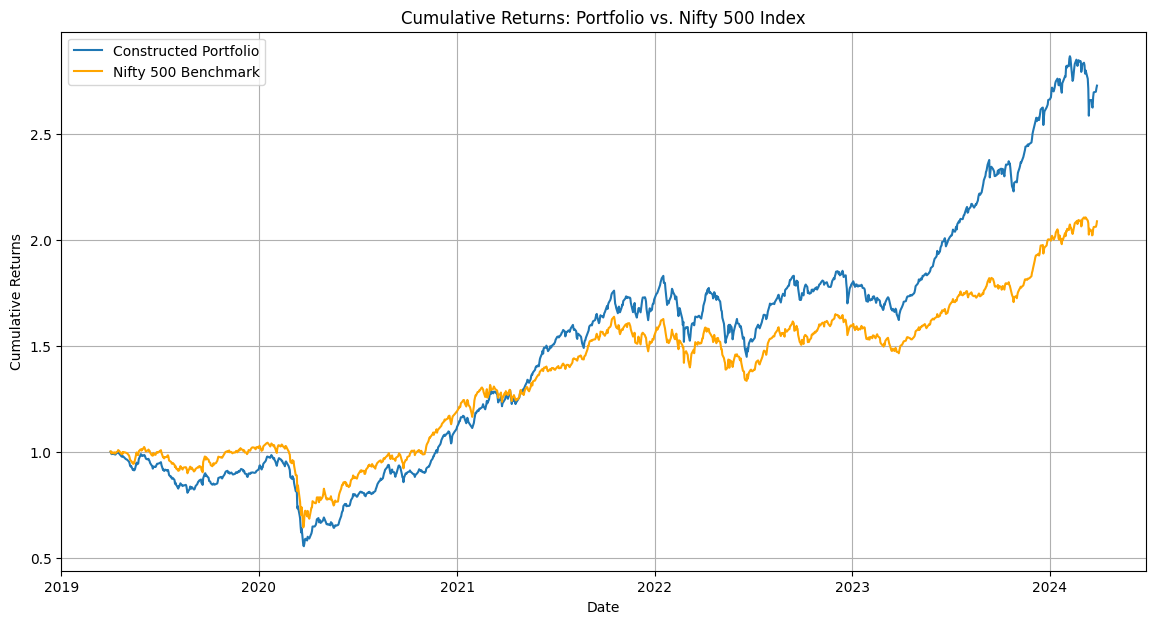

In [43]:
# Ensure the index of cumulative returns are datetime objects
cumulative_portfolio_returns.index = pd.to_datetime(cumulative_portfolio_returns.index)
cumulative_benchmark_returns.index = pd.to_datetime(cumulative_benchmark_returns.index)

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_portfolio_returns, label="Constructed Portfolio")
plt.plot(cumulative_benchmark_returns, label="Nifty 500 Benchmark", color='orange')
plt.title("Cumulative Returns: Portfolio vs. Nifty 500 Index")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Portfolio performance metrics
annualized_return = portfolio_returns.mean() * 252
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print("Enhanced Portfolio Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Benchmark performance metrics
benchmark_annualized_return = benchmark.mean() * 252
benchmark_annualized_volatility = benchmark.std() * np.sqrt(252)
benchmark_sharpe_ratio = benchmark_annualized_return / benchmark_annualized_volatility

print("\nBenchmark Performance Metrics:")
print(f"Annualized Return: {benchmark_annualized_return:.2%}")
print(f"Annualized Volatility: {benchmark_annualized_volatility:.2%}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

Enhanced Portfolio Performance Metrics:
Annualized Return: 22.31%
Annualized Volatility: 18.84%
Sharpe Ratio: 1.18

Benchmark Performance Metrics:
Annualized Return: 16.85%
Annualized Volatility: 18.55%
Sharpe Ratio: 0.91
